### Load Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier, BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, \
                             AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score,  roc_auc_score, mean_squared_error

### Import Data

In [2]:
pokemon = pd.read_csv('/mnt/pokemon.csv')
pokemon.set_index('Name',inplace = True)
pokemon.loc[pokemon['Type 2'].isna(),'Type 2'] = "None"
pokemon.head()

,Number,Type 1,Type 2,Total,HP,Attack,Defense,Spec_Attack,Spec_Def,Speed,Generation,Legendary
Name,,,,,,,,,,,,
Bulbasaur,1,Grass,Poison,318,45,49,49,65,65,45,1,False
Ivysaur,2,Grass,Poison,405,60,62,63,80,80,60,1,False
Venusaur,3,Grass,Poison,525,80,82,83,100,100,80,1,False
VenusaurMega Venusaur,3,Grass,Poison,625,80,100,123,122,120,80,1,False
Charmander,4,Fire,None,309,39,52,43,60,50,65,1,False


### Decision Tree Classifier

In [3]:
X = pokemon[['Type 1','Type 2','HP','Attack','Defense','Spec_Attack','Spec_Def','Speed','Generation']]
y = pokemon['Legendary']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,stratify=y,random_state=1)

In [5]:
dt = DecisionTreeClassifier(max_depth=3,criterion='gini',random_state=1) # criterion = 'entropy'

In [6]:
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
accuracy_score(y_test,y_pred)

0.925

### Decision Tree Regression

In [53]:
X = pokemon[['Type 1','Type 2','HP','Defense','Spec_Attack','Spec_Def','Speed','Generation','Legendary']]
y = pokemon['Attack']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,random_state=1)

In [54]:
dt = DecisionTreeRegressor(max_depth=3,min_samples_leaf=0.1,random_state=1)

In [55]:
MSE_CV = cross_val_score(dt,X_train,y_train,cv=10,scoring='neg_mean_squared_error') * (-1)
print(MSE_CV)
print(np.mean(MSE_CV))

[673.40165674 936.71769571 703.23839807 576.94626542 786.61766717
 666.47336672 600.38853979 630.9053765  709.87904017 962.22841395]
724.6796420245254


In [56]:
dt.fit(X_train,y_train)
y_train_pred = dt.predict(X_train)
rmse_test = mean_squared_error(y_train,y_train_pred)**(.5) # CV error > training error --> fhat has high variance

print('Test Accuracy of CART: {:.3f}'.format(rmse_test))

Test Accuracy of CART: 25.961


### Building an Ensemble

In [24]:
X = pokemon[['Type 1','Type 2','HP','Attack','Defense','Spec_Attack','Spec_Def','Speed','Generation']]
y = pokemon['Legendary']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,stratify=y,random_state=1)

In [30]:
seed = 1
lr = LogisticRegression(random_state=seed)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=seed)

classifiers = [('Logistic Regression',lr),('K Nearest Neighbors',knn),('CART',dt)]

In [31]:
for clf_name, clf in classifiers:
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print('{:s} : {:.3f}'.format(clf_name,accuracy_score(y_test,y_pred)))

Logistic Regression : 0.900
K Nearest Neighbors : 0.925
CART : 0.912


/usr/local/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [35]:
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train,y_train)
y_pred = vc.predict(X_test)

print('Voting Classifier: {:.3f}'.format(accuracy_score(y_test,y_pred)))

Voting Classifier: 0.912


/usr/local/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Bagging

In [37]:
X = pokemon[['Type 1','Type 2','HP','Attack','Defense','Spec_Attack','Spec_Def','Speed','Generation']]
y = pokemon['Legendary']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,random_state=1)

In [44]:
dt = DecisionTreeClassifier(max_depth=5,min_samples_leaf=.05,random_state=1)
bc = BaggingClassifier(base_estimator=dt,n_estimators=300,oob_score=True)

In [45]:
bc.fit(X_train,y_train)
y_pred = bc.predict(X_test)

print('OOB Accuracy of Bagging Classifier: {:.3f}'.format(bc.oob_score_))
print('Test Accuracy of Bagging Classifier: {:.3f}'.format(accuracy_score(y_test,y_pred)))

OOB Accuracy of Bagging Classifier: 0.912
Test Accuracy of Bagging Classifier: 0.887


### Random Forest

In [47]:
X = pokemon[['Type 1','Type 2','HP','Defense','Spec_Attack','Spec_Def','Speed','Generation','Legendary']]
y = pokemon['Attack']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,random_state=1)

In [50]:
rf = RandomForestRegressor(n_estimators=1000,min_samples_leaf=.05,random_state=1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

rmse_test = mean_squared_error(y_test,y_pred)**(.5)
print('Test Accuracy of Random Forest: {:.3f}'.format(rmse_test))

Test Accuracy of Random Forest: 21.863


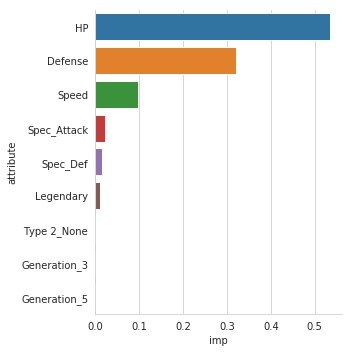

In [74]:
importances_rf = pd.DataFrame({'imp':rf.feature_importances_,'attribute':X_design.columns}).sort_values('imp',ascending=False)
sns.catplot(data=importances_rf[importances_rf['imp']>0],x='imp',y='attribute',kind='bar')

### Adaboost (Adaptive Boosting) Classification

Fit initial model. The points that the model predicts the worst are upweighted and then a new sample is generated. 

In [78]:
X = pokemon[['Type 1','Type 2','HP','Attack','Defense','Spec_Attack','Spec_Def','Speed','Generation']]
y = pokemon['Legendary']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,stratify=y,random_state=1)

In [82]:
dt = DecisionTreeClassifier(max_depth=1,random_state=1)
adb_clf = AdaBoostClassifier(base_estimator=dt,n_estimators=100)

In [86]:
adb_clf.fit(X_train,y_train)
y_pred_proba = adb_clf.predict_proba(X_test)[:,1]
y_pred = adb_clf.predict(X_test)

accuracy = accuracy_score(y_test,y_pred)
auc = roc_auc_score(y_test,y_pred_proba)

print('The accuracy of Adaboost is: {:.3f}'.format(accuracy))
print('The AUC of Adaboost is: {:.3f}'.format(auc))

The accuracy of Adaboost is: 0.938
The AUC of Adaboost is: 0.930


### Gradient Boosting Regression

An initial model is fit. Then, the next model uses the attributes to predict the first model's residuals. 

In [89]:
X = pokemon[['Type 1','Type 2','HP','Defense','Spec_Attack','Spec_Def','Speed','Generation','Legendary']]
y = pokemon['Attack']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,random_state=1)

In [90]:
gbt = GradientBoostingRegressor(n_estimators=300,max_depth=1,random_state=1)
gbt.fit(X_train,y_train)

y_pred = gbt.predict(X_test)
rmse_test = mean_squared_error(y_test,y_pred)**(.5)
print('The RMSE of Gradient Boosting Tree: {:.3f}'.format(rmse_test))

The RMSE of Gradient Boosting Tree: 20.217


### Stochastic Gradient Boosting

Each model is fit using a random subset (40%-80%) of the data, sampled without replacement.

In [ ]:
X = pokemon[['Type 1','Type 2','HP','Defense','Spec_Attack','Spec_Def','Speed','Generation','Legendary']]
y = pokemon['Attack']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,random_state=1)

In [92]:
sgbt = GradientBoostingRegressor(n_estimators=300,max_depth=1,subsample=.8,max_features=.2,random_state=1)
sgbt.fit(X_train,y_train)

y_pred = sgbt.predict(X_test)
rmse_test = mean_squared_error(y_test,y_pred)**(.5)
print('The RMSE of Stochastic Gradient Boosting Tree: {:.3f}'.format(rmse_test))

The RMSE of Stochastic Gradient Boosting Tree: 20.047


### Tuning Hyperparameters for CART

In [93]:
X = pokemon[['Type 1','Type 2','HP','Attack','Defense','Spec_Attack','Spec_Def','Speed','Generation']]
y = pokemon['Legendary']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,stratify=y,random_state=1)

In [95]:
dt = DecisionTreeClassifier()
dt.get_params()

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': None,
 'splitter': 'best'}

In [ ]:
params_dt = {'max_depth': [2,3,4,5,6,7,8,9,10],
             'min_samples_leaf':[0.02,0.04,0.06,0.08,0.10],
             'max_features':[0.2,0.4,0.6,0.8]}

grid_dt = GridSearchCV(estimator=dt,param_grid=params_dt,cv=10)
grid_dt.fit(X_train,y_train)

In [106]:
best_hyperparams = grid_dt.best_params_
best_CV_score = grid_dt.best_score_
print('Optimal hyperparameters: \n',best_hyperparams)
print('Optimal CV accuracy: {:.3f}'.format(best_CV_score))

Optimal hyperparameters: 
 {'max_depth': 6, 'max_features': 0.4, 'min_samples_leaf': 0.02}
Optimal CV accuracy: 0.947


In [109]:
best_model = grid_dt.best_estimator_
test_acc = best_model.score(X_test,y_test)
print('Test accuracy of best model: {:.3f}'.format(test_acc))

Test accuracy of best model: 0.925


### Tune Hyperparameters for Random Forest

In [4]:
X = pokemon[['Type 1','Type 2','HP','Defense','Spec_Attack','Spec_Def','Speed','Generation','Legendary']]
y = pokemon['Attack']

X_design = pd.get_dummies(X,columns=['Type 1','Type 2','Generation']) 
X_design = X_design.drop(['Type 1_Normal','Type 2_Normal','Generation_1'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_design,y,test_size=.2,random_state=1)

In [9]:
rf = RandomForestRegressor(random_state=1)
rf.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)>

In [11]:
params_rf = {'n_estimators':[300,400,500],
             'max_depth':[4,6,8],
             'min_samples_leaf':[0.1,0.2],
             'max_features':['log2','sqrt']}
grid_rf = GridSearchCV(estimator=rf,param_grid=params_rf,cv=5,scoring='neg_mean_squared_error')
grid_rf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=1,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [4, 6, 8],
          

In [12]:
best_hyperparams = grid_rf.best_params_
best_model = grid_rf.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test,y_pred)**(0.5)

print('Best HPs for RF: \n',best_hyperparams)
print('Test set RMSE of RF: {:.3F}'.format(rmse_test))

Best HPs for RF: 
 {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'n_estimators': 400}
Test set RMSE of RF: 25.813
